In [27]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import ClimateVR
from sdice_model import SimplifiedDICE, ScenarioDICE
from portfolio import PortfolioOptimizer

In [28]:
# Instancia para limpiar y procesar los datos
climate_data = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx').clean_and_prepare_data()
economic_data = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv').clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
gray_a = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA']
green_a = ['NEE', 'FSLR', 'VWDRY', 'BEP']
assets = gray_a + green_a
benchmark = '^GSPC'
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

# Fusiona los datos
data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
e_eco_data = pd.merge(economic_data, climate_data, on='Date').iloc[:-1]

gray_data = all_data[gray_a]  
green_data = all_data[green_a]
all_data.drop('Date', axis=1, inplace=True)
e_eco_data.drop('Date', axis=1, inplace=True)


[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [29]:
e_eco_data

,GDP,TB3MS,CPI,Temperature,DSCI,Coal,Natural Gas,Petroleum,Total CO2 Emissions
0,17912.079,0.02,237.430,3.434062,104.00,-0.107713,-0.079697,0.035305,-0.045066
1,18063.529,0.03,234.747,0.239178,103.25,-0.140308,-0.024601,0.005973,-0.049579
2,18063.529,0.03,234.747,0.835308,111.25,-0.117793,0.071572,0.034858,-0.002740
3,18063.529,0.03,234.747,2.247921,117.20,-0.185240,0.017076,0.057500,-0.029565
4,18279.784,0.02,236.222,0.825789,125.25,-0.163193,0.027977,0.012721,-0.034143
...,...,...,...,...,...,...,...,...,...
107,27956.998,5.34,307.531,1.999337,124.75,-0.087308,0.020830,0.012984,-0.000491
108,27956.998,5.34,307.531,2.834145,114.50,-0.225731,-0.062126,0.004378,-0.064475
109,28269.174,5.22,309.685,-2.182826,98.80,0.167510,0.120100,0.010273,0.081480
110,28269.174,5.22,309.685,2.395689,72.75,-0.041299,0.006871,0.007048,0.000088


In [30]:
# Instanciar el modelo ClimateVR con los datos
vr_model = ClimateVR(e_eco_data)

# Optimizar el número de retardos usando Optuna
optimal_maxlags, optimal_rmse = vr_model.optimize_maxlags(all_data=e_eco_data, n_trials=100)
print(f'Número óptimo de retardos: {optimal_maxlags}')
print(f'RMSE óptimo: {optimal_rmse}')

# Ajustar el modelo VR con el número óptimo de retardos
vr_results = vr_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = vr_model.predict(vr_results, lags=optimal_maxlags, end=len(e_eco_data))


Número óptimo de retardos: 10
RMSE óptimo: 9423.702735091494


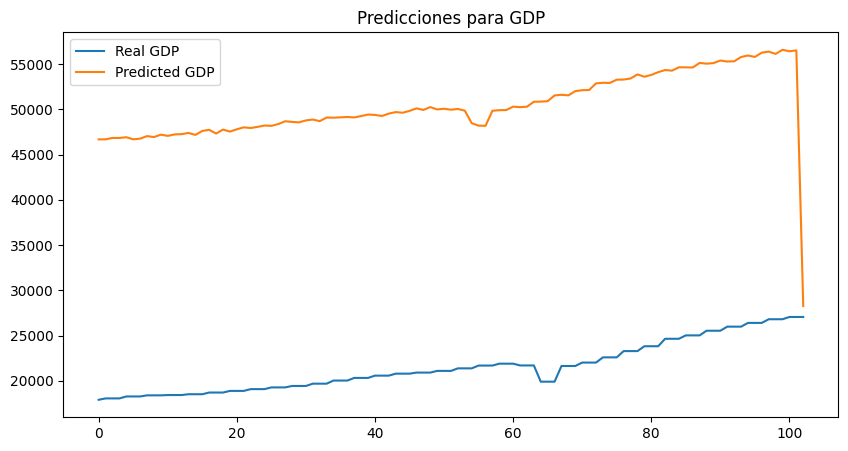

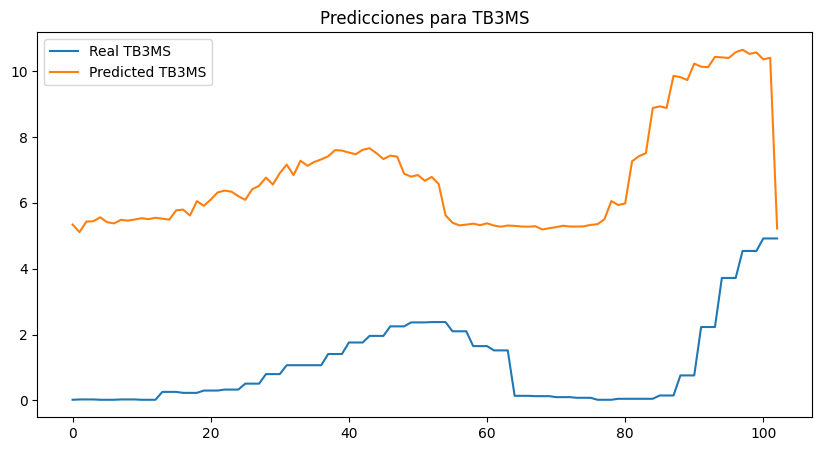

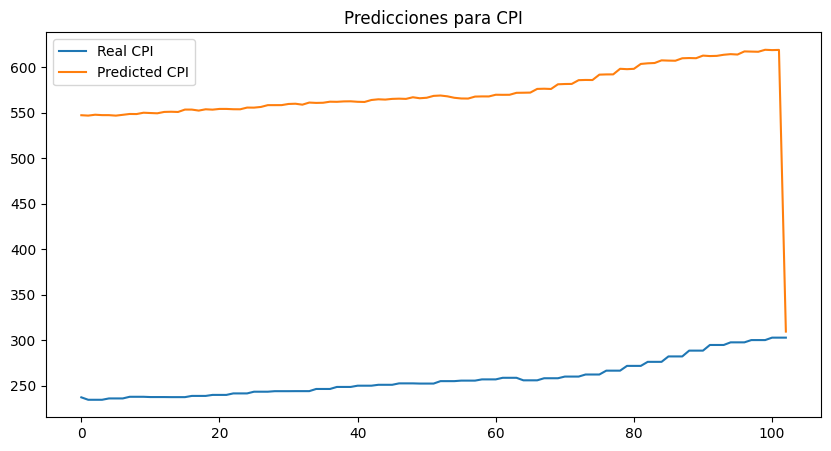

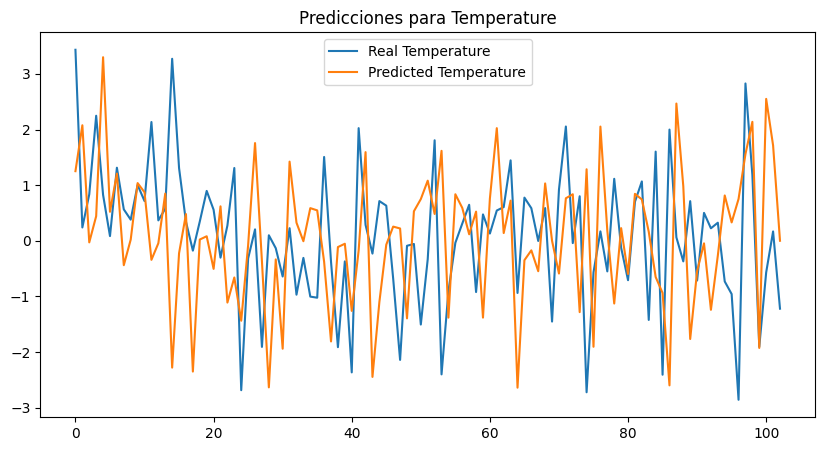

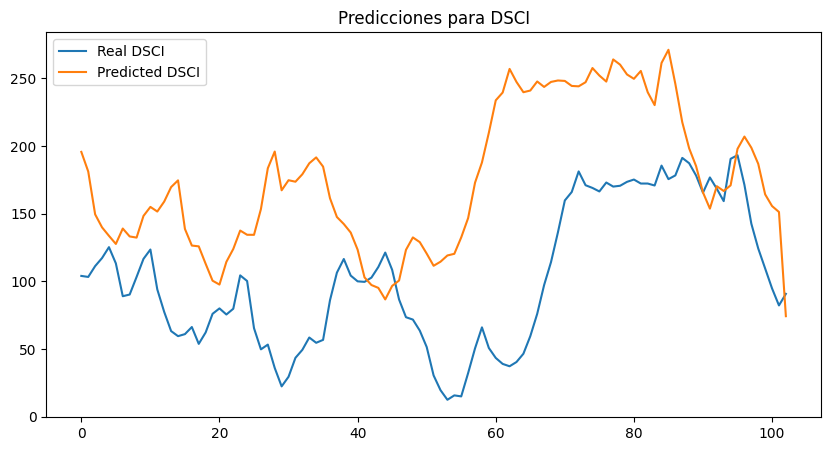

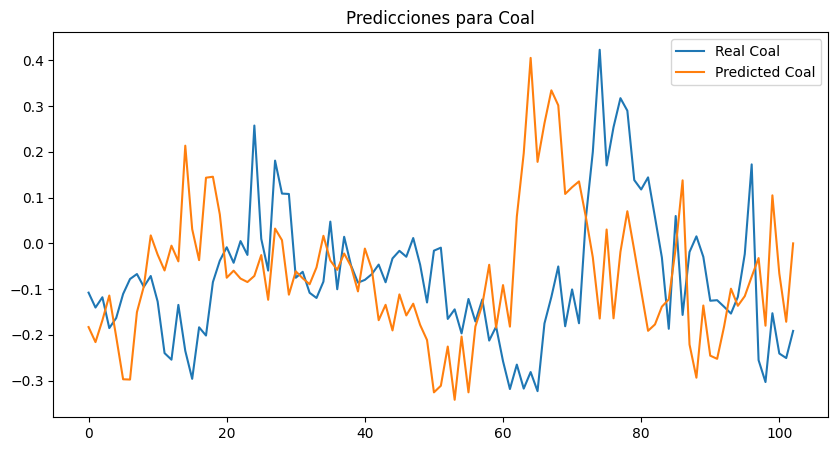

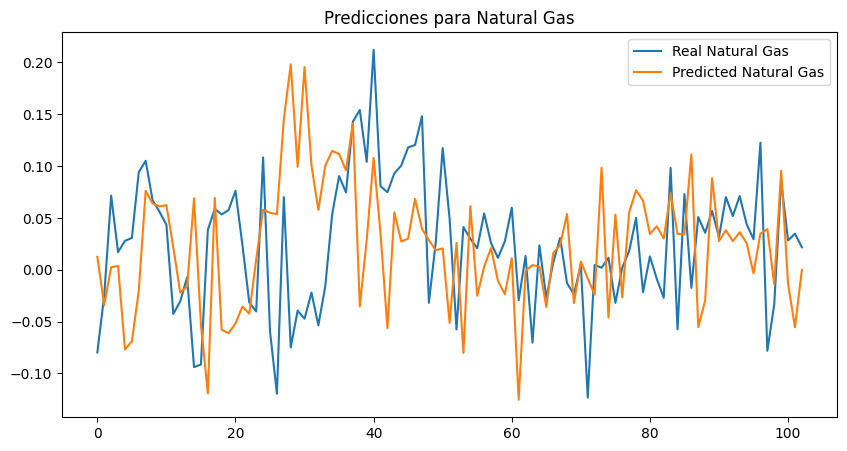

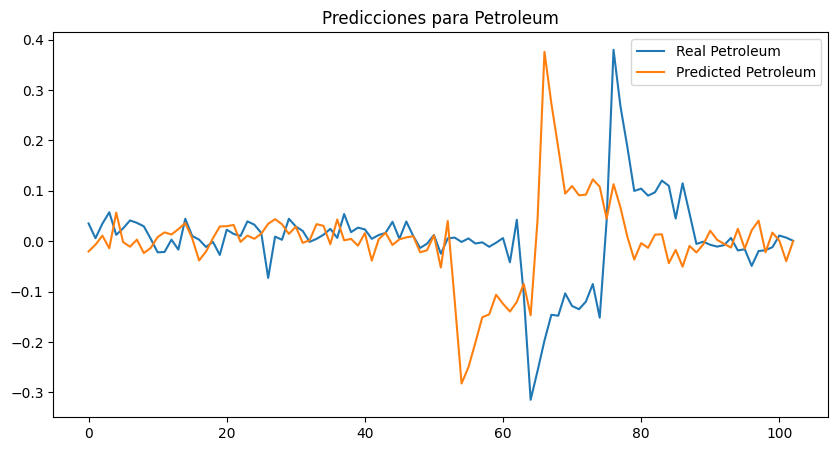

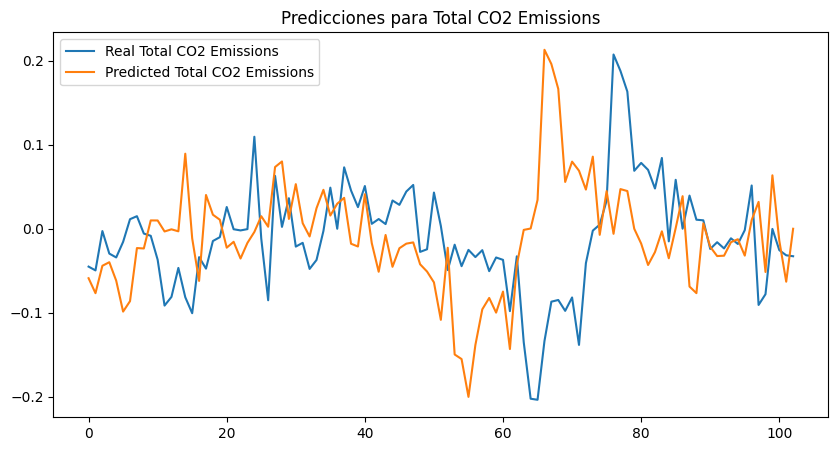

In [31]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(e_eco_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(e_eco_data.index[:len(predict)], e_eco_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(e_eco_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

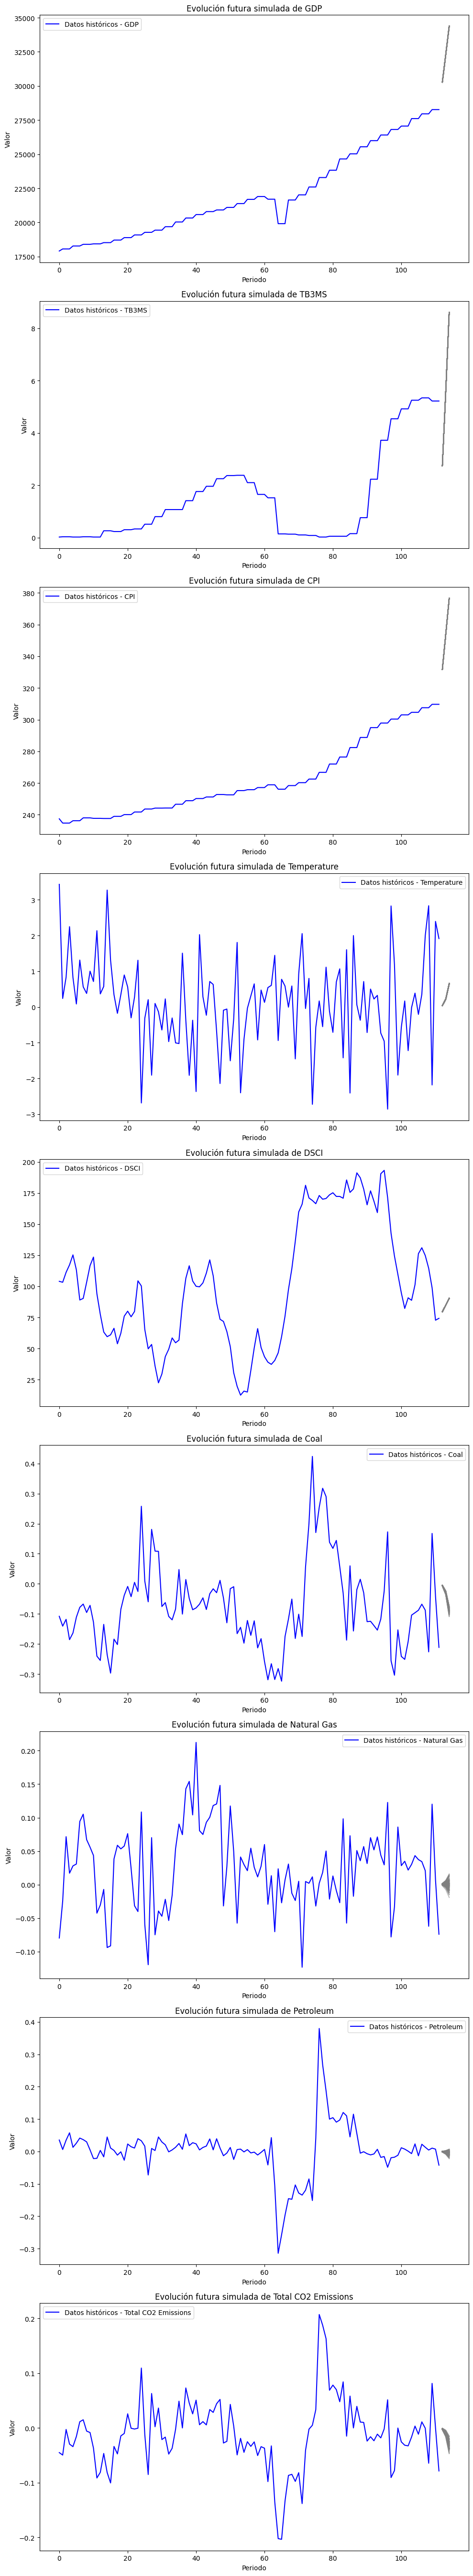

In [32]:

# Graficar los resultados para cada variable no financiera, incluyendo datos históricos
n_variables = vr_model.neqs
fig, axs = plt.subplots(n_variables, 1, figsize=(10, 6 * n_variables))

for var_idx, var_name in enumerate(vr_model.endog.columns):
    
    # Graficar datos históricos
    axs[var_idx].plot(vr_model.endog.index, vr_model.endog.iloc[:, var_idx], label=f'Datos históricos - {var_name}', color='blue')

    # Crear un índice para los 3 periodos futuros (continuando desde los datos históricos)
    future_index = range(len(vr_model.endog), len(vr_model.endog) + 3)
    
    # Graficar escenarios futuros para los próximos 3 periodos
    for scenario in range(100):
        try:
            axs[var_idx].plot(future_index, scenarios[var_name][:, scenario], color='gray', alpha=0.5)
        except Exception as e:
            print(f"Error al graficar la variable {var_name}: {e}")
    
    axs[var_idx].set_title(f'Evolución futura simulada de {var_name}')
    axs[var_idx].set_xlabel('Periodo')
    axs[var_idx].set_ylabel('Valor')
    axs[var_idx].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Instanciar la clase ScenarioDICE
scenario_dice = ScenarioDICE()

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

In [ ]:
# Alinear asset_prices y benchmark_prices según el índice (fechas o índices comunes)
asset_prices, benchmark_prices = asset_prices.align(benchmark_prices, join='inner', axis=0)

# Inicializar el optimizador de portafolios
optimizer = PortfolioOptimizer(asset_prices=asset_prices, risk_free_rate=rf, benchmark_prices=benchmark_prices)
num_portfolios = 100000
strategies = ['sharpe', 'omega', 'sortino']  # Puedes elegir las estrategias que quieras

# Optimizar el portafolio utilizando múltiples estrategias
optimal_portfolios, ranked_portfolios_df = optimizer.optimize_with_multiple_strategies(num_portfolios=num_portfolios, strategies=strategies)

# Diccionario para almacenar los datos de portafolios
portfolios_data = {
    'strategy': [],
    'portfolio': [],
    'weights': [],
    'score': [],
    'jensen_alpha': [],
    'adjusted_return': []
}

# Iterar sobre las estrategias y los portafolios optimizados
for strategy, portfolios in optimal_portfolios.items():
    for i, (weights, score, adjusted_return) in enumerate(portfolios[:5]):  # Muestra los 5 mejores portafolios
        # Calcular Jensen's Alpha
        jensen_alpha = optimizer.calculate_jensen_alpha(weights)

        # Añadir los resultados al diccionario
        portfolios_data['strategy'].append(strategy)
        portfolios_data['portfolio'].append(f'Portafolio {i+1}')
        portfolios_data['weights'].append(weights)
        portfolios_data['score'].append(score)
        portfolios_data['jensen_alpha'].append(jensen_alpha)
        portfolios_data['adjusted_return'].append(adjusted_return)

# Convertir el diccionario en un DataFrame
portfolios_df = pd.DataFrame(portfolios_data)

# Imprimir todos los portafolios
print(portfolios_df)

In [ ]:
# Buscar el portafolio con el mejor score
best_portfolio = portfolios_df.loc[portfolios_df['score'].idxmax()]

# Calcular el retorno promedio del mejor portafolio
average_return = np.mean(best_portfolio['adjusted_return'])

# Imprimir el mejor portafolio con su retorno promedio
print(f"\nRetorno promedio del mejor portafolio: {average_return:.4f}")
best_portfolio
